In [22]:
"""
# Explaniable AI
# 会使用到 Ex2 的模型和数据等
"""

'\n# Explaniable AI\n# 会使用到 Ex2 的模型和数据等\n'

In [23]:
#prepare
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
import cv2

In [24]:
#HW_5 开始
class Classfication(nn.Module):
    def __init__(self):
        super(Classfication,self).__init__()
        #tensor 128* 128*128*3
        self.conv1 = nn.Conv2d(3,64,3)
        #126*126
        self.conv2 = nn.Conv2d(64,128,3)
        #128 *20 * 30 *30
        self.fc1 = nn.Linear(128*30*30,100)
        self.fc2 = nn.Linear(100,11)
    
    def forward(self,x):
        in_size = x.size(0)
        #126
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out,2,2)
        # 63
        out = self.conv2(out)
        # 61
        out = F.relu(out)
        out = F.max_pool2d(out,2)
        # 如果向下取整 30 
        # print(out.shape)
        out = out.view(in_size,-1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        # out = F.log_softmax(out,dim=1)
        return out

In [25]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,5),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,5),
            nn.ReLU()
        )
        #3x3 池化
        self.max_pool1 = nn.MaxPool2d(3,2)
        self.max_pool2 = nn.MaxPool2d(3,2)
        self.fc1 = nn.Linear(128*28*28,1000)
        self.fc2 = nn.Linear(1000,11)
    
    def forward(self,x):
        out = self.conv1(x)
        #batch 64 124 124
        out = self.max_pool1(out)
        #64 62 62 
        out = self.conv2(out)
        #64 58 58
        out = self.max_pool2(out)
        #128 29 29
        out = out.view(out.shape[0],-1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [26]:
# 這是助教的示範 model，寫作業時一樣要換成自己的
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = Classifier().to(device)
checkpoint = torch.load('./data/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

cuda


<All keys matched successfully>

In [30]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
     # 這個 method 並不是 pytorch dataset 必要，只是方便未來我們想要指定「取哪幾張圖片」出來當作一個 batch 來 visualize
    def getbatch(self,indices):
        images= []
        labels= []
        for index in indices:
            image,label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images),torch.tensor(labels)

def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path,name))
        labels.append(int(name.split('_')[0]))
    return imgpaths,labels
train_paths,train_labels = get_paths_labels('../HW_3/data/training')
workspace_dir = '../HW_3/data/'
print("reading data...")
def readfile(path,label):
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir),128,128,3),dtype=np.uint8)
    y = np.zeros((len(image_dir)),dtype=np.uint8)
    for i,file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path,file))
        x[i,:,:] = cv2.resize(img,(128,128))
        if label:
            y[i] = int(file.split("_")[0])
    if label:
        return x,y 
    else:
        return x

train_x,train_y = readfile(os.path.join(workspace_dir,"training"),True)
train_set = ImgDataset(train_x,train_y,test_transform)


reading data...


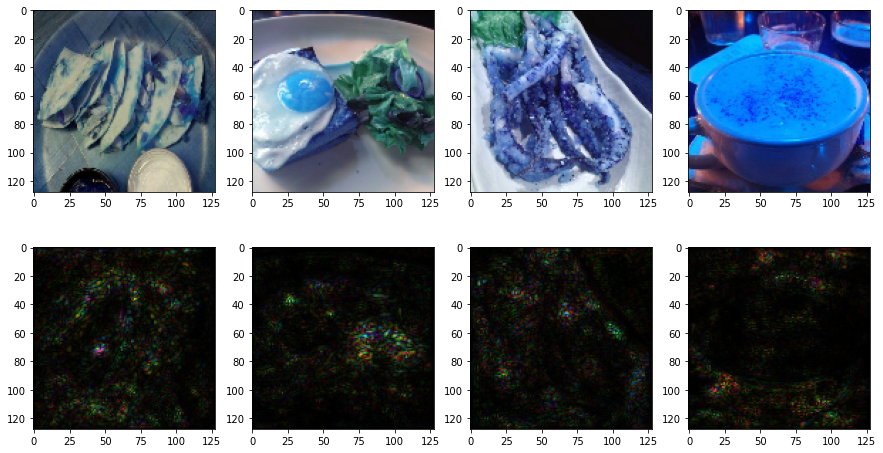

In [35]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.to(device)

    # 最關鍵的一行 code
    # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
    # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.to(device))
    loss.backward()

    saliencies = x.grad.abs().detach().cpu()
    # saliencies: (batches, channels, height, weight)
    # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
    # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
    # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
    # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
    # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies
#
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 使用 matplotlib 畫出來
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # 小知識：permute 是什麼，為什麼這邊要用?
    # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
    # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
    # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
    # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
    # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
    # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
    # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

plt.show()
plt.close()


In [44]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

layer_activations = None
def filter_explaination(x,model,cnnid,filterid,iteration=100,lr =0.01):
    model.eval()
    def hook(model,input,output):
        global layer_activations
        layer_activations = output

    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    model(x.to(device))

    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

    x = x.to(device)
    x.requires_grad_()
    optimizer = Adam([x],lr =lr)
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)
        objective = -layer_activations[:, filterid, :, :].sum()
        objective.backward()
        optimizer.step()
    filter_visualization = x.detach().cpu().squeeze()[0]
    hook_handle.remove()
    return filter_activations,filter_visualization


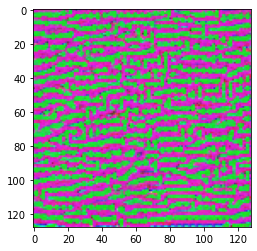

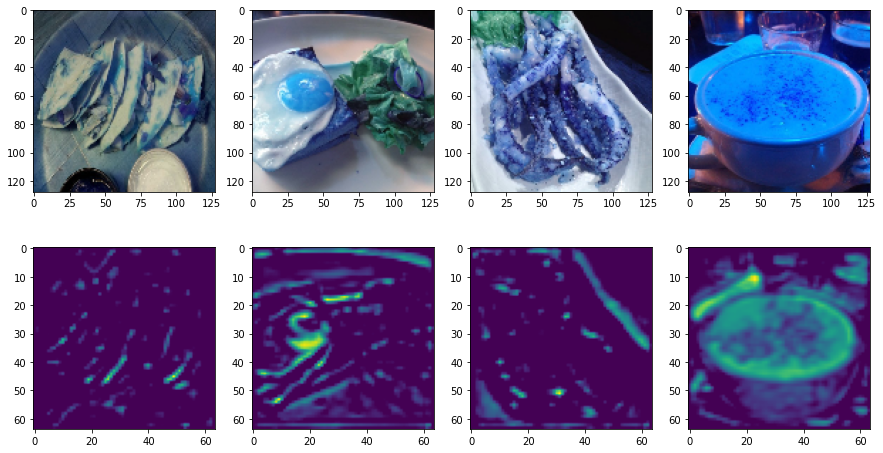

In [46]:
img_indices = [83,4218,4707,8598]
images,labels = train_set.getbatch(img_indices)
filter_activations,filter_visulization = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

plt.imshow(normalize(filter_visulization.permute(1,2,0)))
plt.show()
plt.close()

fig,axs = plt.subplots(2,len(img_indices),figsize=(15,8))
for i,img in enumerate(images):
    axs[0][i].imshow(img.permute(1,2,0))
for i,img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))

plt.show()
plt.close()

<ipython-input-48-c26e9ebdea78>:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return slic(input, n_segments=100, compactness=1, sigma=1)
100%|██████████| 1000/1000 [00:10<00:00, 92.73it/s]


KeyError: 'Label not in explanation'

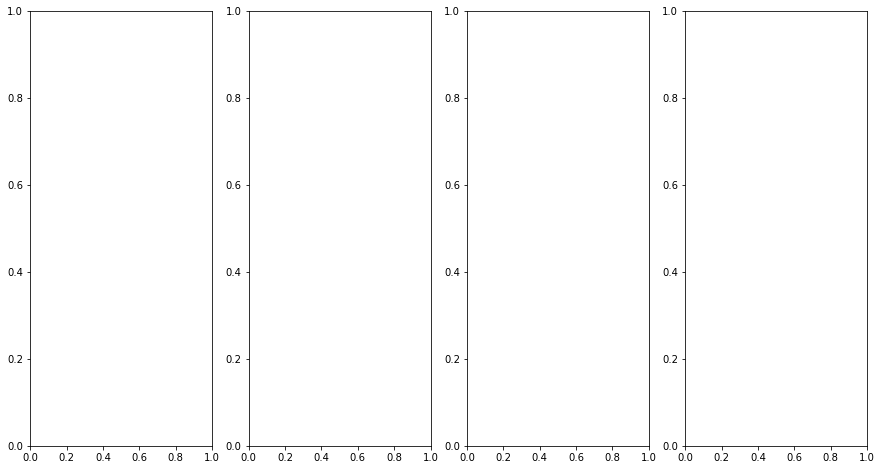

In [48]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.to(device))                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )

    axs[idx].imshow(lime_img)

plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。